In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import mediapipe as mp
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [14]:
# Paths
dataset = './dataset/'
train_dataset = './train-dataset/'

# Ensure output directory exists
os.makedirs(train_dataset, exist_ok=True)

In [15]:
# Display image
def display(image, palette='gray', title=None):
    plt.imshow(image, cmap=palette)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# preprocess image
def img_preprocess(impath):
    img = Image.open(impath)
    img = img.resize(size=(28, 28))  # Resize to 28x28
    img = img.convert('L')  # Convert to grayscale
    img = np.array(img) / 255.0  # Normalize pixel values
    img = img.reshape(1, 28, 28, 1)  # Add batch and channel dimensions
    return img


# Binarization
def binarization_thresholding(image, threshold):
    binarized_image = np.where(image < threshold, 255, 0).astype(np.uint8)
    return binarized_image


# Save binarized image
def save_binarized_image(image, filename, save_path):
    binarized_image_path = os.path.join(save_path, f"binarized-{filename}")
    cv2.imwrite(binarized_image_path, image)
    return binarized_image_path

In [16]:
mp_hands = mp.solutions.hands

for image_file in os.listdir(dataset):
    image_path = os.path.join(dataset, image_file)

    if not (image_file.endswith(".jpg") or image_file.endswith(".png") or image_file.endswith(".jpeg")):
        continue

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Convert image to RGB for MediaPipe
    image_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            for i, hand_landmarks in enumerate(results.multi_hand_landmarks):
                h, w, _ = image_rgb.shape
                x_min, y_min = w, h
                x_max, y_max = 0, 0

                for landmark in hand_landmarks.landmark:
                    x, y = int(landmark.x * w), int(landmark.y * h)
                    x_min = min(x_min, x)
                    y_min = min(y_min, y)
                    x_max = max(x_max, x)
                    y_max = max(y_max, y)

                padding = 30
                x_min = max(0, x_min - padding)
                y_min = max(0, y_min - padding)
                x_max = min(w, x_max + padding)
                y_max = min(h, y_max + padding)

                hand_crop = image_rgb[y_min:y_max, x_min:x_max]
                cropped_hand_gray = cv2.cvtColor(hand_crop, cv2.COLOR_BGR2GRAY)
                threshold_value = 90
                binarized_image = binarization_thresholding(cropped_hand_gray, threshold_value)

                save_filename = f"{os.path.splitext(image_file)[0]}.png"
                save_binarized_image(binarized_image, save_filename, train_dataset)
        else:
            print(f"No hands detected in: {image_file}")


I0000 00:00:1733335589.802602  250759 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733335589.804610  258093 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: Mesa Intel(R) Graphics (ADL GT2)
W0000 00:00:1733335589.838418  258083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733335589.858225  258086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733335589.917203  250759 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733335589.918237  258108 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: Mesa Intel(R) Graphics (ADL GT2)
W0000 00:00:1733335589.941748  258095 inference_feedback_manager.cc:114] Feedback manager 

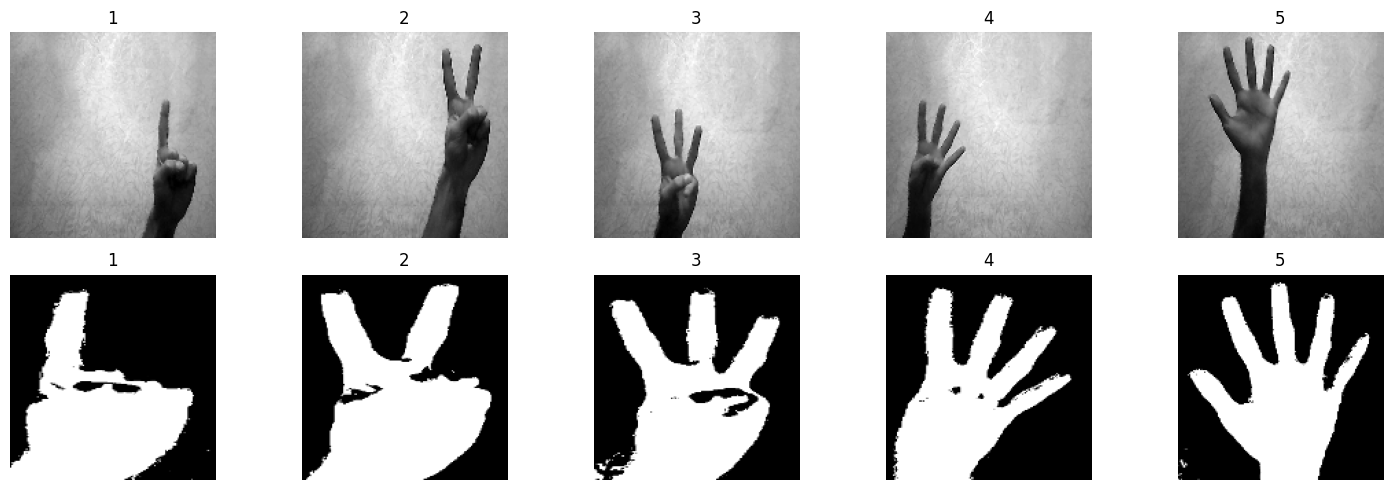

In [17]:
# Create subplots for displaying both datasets
fig, axes = plt.subplots(2, 5, figsize=(15, 5))  # 2 rows, 5 columns

def datasetPlot(foldername, axes):
    for i, ax in enumerate(axes, start=1):
        filename = f"{foldername}{i}-frame00231.png"
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            resized_image = cv2.resize(image, (150, 150))
            ax.imshow(resized_image, cmap='gray')
            ax.set_title(f"{i}")
            ax.axis('off')
        else:
            ax.axis('off')
            ax.set_title("Error")

# First call to plot from 'dataset'
datasetPlot(f"{dataset}", axes[0])

# Second call to plot from 'train_dataset'
datasetPlot(f"{train_dataset}binarized-", axes[1])

plt.tight_layout()  # Adjust layout
plt.show()

In [18]:
def load_imgs(impath):
    imgs = []
    labels = []
    l1 = os.listdir(impath)
    
    for i in l1:
        full_path_i = os.path.join(impath, i)

        if os.path.isfile(full_path_i):
            img = Image.open(full_path_i)
            img = img.resize(size=(28, 28))
            img = img.convert('L')
            imgs.append(np.array(img).flatten() / 255.0)
            labels.append(int(i.split(sep='-')[1]))
        elif os.path.isdir(full_path_i):
            l2 = os.listdir(full_path_i)
            for j in l2:
                img_path = os.path.join(full_path_i, j)
                img = Image.open(img_path)
                img = img.resize(size=(28, 28))
                img = img.convert('L')
                imgs.append(np.array(img).flatten() / 255.0)
                labels.append(int(j.split(sep='-')[1]))

    return np.array(imgs), np.array(labels)

In [19]:
imgs, labels = load_imgs(train_dataset)
imgs.shape, labels.shape, labels

((332, 784),
 (332,),
 array([2, 3, 2, 5, 4, 2, 3, 2, 2, 5, 4, 5, 2, 5, 5, 5, 4, 3, 4, 5, 3, 4,
        3, 2, 4, 3, 5, 5, 5, 5, 5, 4, 3, 5, 1, 5, 2, 1, 4, 1, 4, 5, 2, 5,
        1, 4, 5, 1, 3, 3, 1, 3, 4, 3, 1, 2, 2, 3, 2, 4, 1, 1, 1, 5, 4, 2,
        3, 2, 1, 2, 2, 3, 4, 5, 3, 5, 4, 1, 4, 1, 3, 3, 1, 4, 2, 2, 3, 2,
        1, 4, 5, 4, 2, 3, 2, 2, 1, 3, 1, 2, 1, 4, 2, 2, 5, 5, 5, 3, 1, 4,
        3, 2, 5, 1, 5, 4, 4, 1, 4, 1, 2, 3, 3, 5, 2, 4, 2, 5, 1, 1, 5, 2,
        3, 5, 4, 3, 1, 4, 2, 5, 1, 4, 1, 3, 3, 2, 2, 3, 3, 5, 2, 3, 5, 2,
        1, 1, 4, 2, 4, 5, 1, 4, 3, 3, 2, 5, 3, 3, 1, 5, 4, 4, 2, 2, 1, 1,
        4, 4, 4, 4, 3, 5, 5, 5, 4, 3, 5, 5, 3, 3, 3, 5, 5, 4, 3, 2, 5, 3,
        4, 5, 1, 5, 3, 2, 4, 2, 5, 5, 2, 3, 5, 4, 4, 3, 3, 3, 5, 5, 4, 2,
        1, 2, 3, 1, 1, 5, 1, 5, 5, 4, 5, 4, 3, 2, 4, 5, 2, 2, 4, 1, 2, 2,
        5, 1, 4, 4, 5, 5, 1, 1, 5, 2, 4, 3, 3, 1, 1, 2, 4, 1, 1, 1, 3, 1,
        3, 3, 4, 3, 1, 2, 1, 4, 4, 4, 1, 4, 4, 3, 2, 3, 2, 3, 3, 1, 2, 4,
        1, 2, 1,

In [20]:
x_train, y_train = imgs, labels
x_test, y_test = imgs, labels

# Reshape and normalize
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0

# One-hot encode labels
y_train_vec = to_categorical(y_train, num_classes=6)
y_test_vec = to_categorical(y_test, num_classes=6)

# Print the shapes
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train_vec shape:', y_train_vec.shape)
print('y_test_vec shape:', y_test_vec.shape)

x_train shape: (332, 28, 28, 1)
x_test shape: (332, 28, 28, 1)
y_train_vec shape: (332, 6)
y_test_vec shape: (332, 6)


In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/home/asim/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,116,550 (4.26 MB)

 Trainable params: 1,116,550 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(x_train, y_train_vec,
                    batch_size=32,
                    epochs=50,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.2146 - loss: 1.7650 - val_accuracy: 0.0882 - val_loss: 1.6710
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.1795 - loss: 1.6678 - val_accuracy: 0.1471 - val_loss: 1.6348
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.2142 - loss: 1.6364 - val_accuracy: 0.1471 - val_loss: 1.6504
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1982 - loss: 1.6448 - val_accuracy: 0.0882 - val_loss: 1.6488
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1497 - loss: 1.6423 - val_accuracy: 0.0882 - val_loss: 1.6319
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.1763 - loss: 1.6289 - val_accuracy: 0.3235 - val_loss: 1.6082
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.2190 - loss: 1.6232 - val_accuracy: 0.1471 - val_loss: 1.6424
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.2165 - loss: 1.6117 - val_accuracy: 0.1471 - v

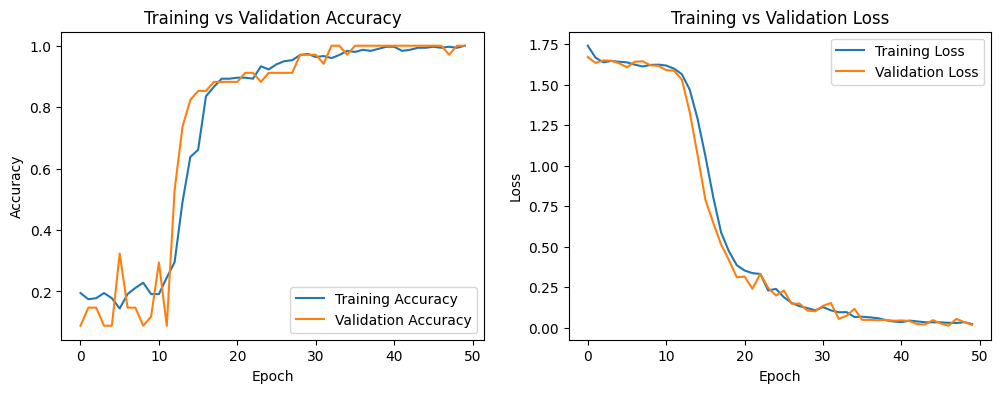

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


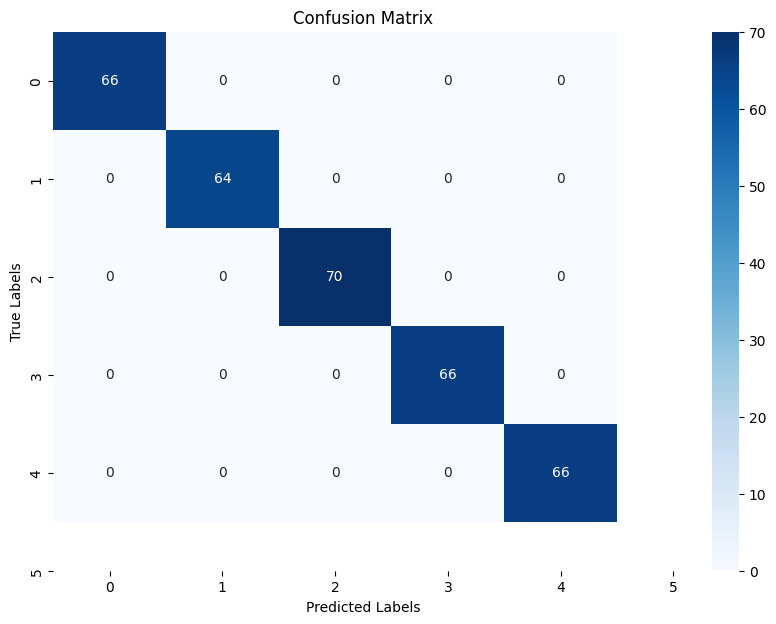

In [24]:
y_pred = model.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_vec, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(6), yticklabels=np.arange(6))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [25]:
img_path = './train-dataset/binarized-5-frame00051.png'

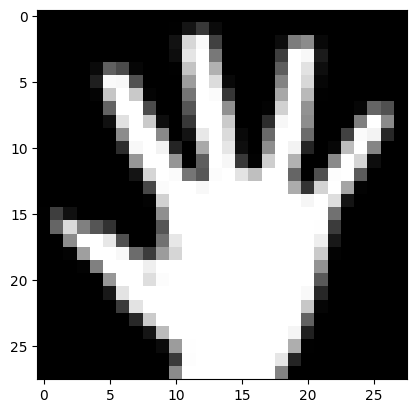

In [26]:
img = img_preprocess(img_path)
# Display the image
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.show()

In [27]:
prediction = np.argmax(model.predict(img))
probabilities = model.predict(img)
print("Probabilities: ", probabilities)
prediction = np.argmax(probabilities)
print("Predicted class:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Probabilities:  [[0. 0. 0. 0. 0. 1.]]
Predicted class: 5
